# Self Organizing Maps

In [1]:
import numpy as np

# graphics
import matplotlib.pyplot as plt
# import matplotlib as mpl
from IPython.display import display, Image

# contour plots 
import matplotlib.cm as cm

# 3D plots
from mpl_toolkits.mplot3d.axes3d import Axes3D

import sys # system library
sys.path.append('./lib_nn') # my path (linux, Mac OS)

from neural import * # import my library packages

Invoking __init__.py for neural


A very important and ingenious application of unsupervised learning are the so-called **Kohonen nets** ([Teuvo Kohonen](https://en.wikipedia.org/wiki/Teuvo_Kohonen), i.e. **self-organizing mappings preserving topology**. Consider a mapping

$$ N \to D = f (N), $$

where  $N$ is a discrete $k$-dimensional set (grid) of neurons and $D$ is a set of $n$-dimensional input data (continuous or discrete). Since $N$ is discrete, each neuron carrries an index consisting of $k$ natural numbers, denoted as $\bar {i} = (i_1, i_2, ..., i_k)$. Typically, the dimensions satisfy $n \ge k$. When $n > k$, one talks about **reduction of dimensionality**, as the input space $D$ has more dimensions than the space of neurons. 

Two examples of such networks are visualized in {numref]`koh-fig`.

:::{figure-md} koh-fig

<img src="images/koh.png" width="500px">

Example of Kohonen networks. Left: 1-dim. grid of neurons $N$ and 2-dim. input space $D$. Right: 2-dim. grid of neurons $N$ and 3-dim. input space $D$. The gray oval indicates the neighborhood of the winner neuron.
:::

One defines the neuron **proximity function**, $\phi (\bar {i}, \bar {j})$, which assigns, to a pair of neurons, a real number depending on their relative position in the grid. This function must decrease with the distance between the neuron indices. A popular choice is a Gaussian,

$$ \phi(\bar{i}, \bar{j})=\exp\left [ -\frac{(i_1-j_1)^2+...+(i_k-j_k)^2}{2 \delta^2} \right ] ,$$

where $\delta$ is the **neighborhood radius**.

```{note}
Kohonen networks have the property that when two neurons $\bar{i}$ and $\bar{j}$ are close to each oher, then also their mappings into $D$ are close, i.e. $f(\bar{i})$ is close to $f(\bar{j})$. This feature leads, as we will see, to **preservation of topology**. Loosly speaking, when $n=k$, shapes in the input space are carried over to shapes in the neuron grid. 
```

## Kohonen's algorithm

The set up of Kohonen's algorithm is similar to the unsupervised learning discussed in the previous chapter. Each neuron has weights, which are elements of $D$, i.e. form $n$-dimensional vectors. One may simply think of this as placing the neurons in some locations in $D$. When an input point $P$ form $D$ is fed into the network, one looks for a closest neuron, the **winner**, exactly as in the algorithm from section {ref}`inn-sec`. However, here comes an important differeence. Not only the winner is attracted a bit towards $P$, but also its neighbors, to a lesser and lesser extent the farther they are from the winner.

```{admonition} Winner-take most strategy
:class: important

Kohonen's algorithm involves the "winner take most" strategy, where not only the winner neuron is updated (as in the winner-take-all case), but also its neighbors. The neighbors update is strongest for the nearest neighbors, and gradually weakens with the distance from the winner.  
```

```{admonition} Kohnen's algorithm
:class: important

0. Initialize (for instance randomly) $n$-dimensional weights $w_i$ for all the $m$ neurons. Set an initial neighborhood radius $ \delta $ and the learning speed $ \varepsilon $.

1. Choose (randomly) a data point $P$ wigh coordinates $x$ from the input space (possibly with an appropriate probability distribution).

2. Find the $ \bar {l} $ neuron (the winner) for which the distance from $P$ is the smallest.

3. The weights of the winner and its neighbors are updated according to the **winner take most** recipe:

$$w_{\bar{i}} \to w_{\bar{i}} + \varepsilon \phi(\bar{i}, \bar{l})(x - w_{\bar{i}}), \hspace{1cm} i=1, . . . , m. 
$$

4. Loop from $1.$ for a specified number of points. 

5. Repeat from $1.$ in rounds, until a satisfactory result is obtained or the maximum number of rounds is reached. In each round  **reduce** $ \varepsilon $ and $ \delta $ according to a chosen policy. 
```

The way the reduction of $ \varepsilon $ and $ \delta $ is done is important for the desired outcome of the algorithm (see homework problems). 


## Mapping of a 1-dim. network of neurons into 2-dim. data

Let us see how the procedure works on a simple example. We will map a grid of **num** neurons into (our favorite!) circle. So we have here the reduction of dimensions: $n=2$, $k=1$. 

In [2]:
num=100 # number of neurons

The proximity function

In [3]:
def phi(i,k,d):                       # proximity function
    return np.exp(-(i-k)**2/(2*d**2)) # Gaussian

looks like this around $k=50$ and for the width parameter $\delta=5$:

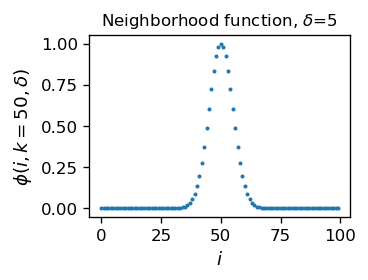

In [4]:
k=50
d=5

plt.figure(figsize=(2.8,2),dpi=120)
plt.title("Neighborhood function, $\delta$="+str(d),fontsize=10) 

ind=[i for i in range(num)]
ph= [phi(i,k,d) for i in range(num)]

plt.scatter(ind,ph,s=2)

plt.xlabel('$i$',fontsize=11)
plt.ylabel('$\phi(i,k=$'+str(k)+'$,\delta)$',fontsize=11);    

At $|k-i|=\delta$ it drops to $~60\%$ of the central value, and at $|k-i|=3\delta$ to $~1\%$, a tiny fraction. Hence $\delta$ controls the size of the neighborhood of the winner. The neuron farther away from the winner than $3\delta$ are practically left unupdated. 

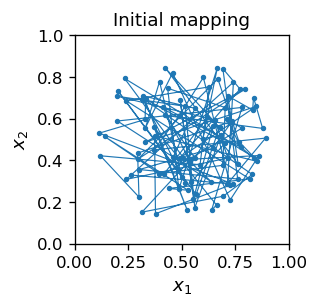

In [5]:
W=np.array([func.point_c() for _ in range(num)]) # random initialization of weights

plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Initial mapping",fontsize=11) 
plt.xlim(0,1)
plt.ylim(0,1)

plt.scatter(W[:,0],W[:,1],s=5)
plt.plot(W[:,0],W[:,1],linewidth=0.7)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11);    

The line connects the subsequent neurons ... They are chaotically scattered around the region.

In [6]:
eps=.5   # initial learning speed (0.5)
de = 10  # initial neighborhood distance (10)

In [7]:
# Kohonen's algorithm
for _ in range(50): # rounds
    eps=eps*.98 # learning speed drops
    de=de*.95   # and so does the neighborhood distance
    for _ in range(100): # loop over points
        p=func.point_c()        # random point
        dist=[func.eucl(p,W[k]) for k in range(num)] 
         # array of Euclidean disances from the neuron locations
#        print(np.round(dist,3))
        ind_min = np.argmin(dist) # index of the winner
#        print(ind_min)
        for k in range(num): 
            W[k]+=eps*phi(ind_min,k,de)*(p-W[k]) 
             # update of the neuron locations

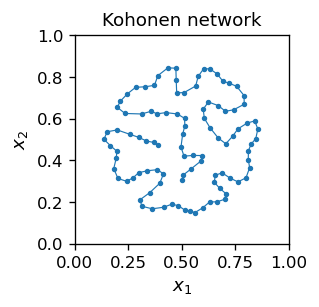

In [8]:
fk=plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Kohonen network",fontsize=11) 
plt.xlim(0,1)
plt.ylim(0,1)
 
plt.scatter(W[:,0],W[:,1],s=5)
plt.plot(W[:,0],W[:,1],linewidth=0.7)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11);    


Figuratively speaking, the point $ x $ attracts the nearest neuron and (to a weaker extent) its neighbors. After several learning steps, individual neurons "specialize" (are close to) in a certain data area. It is the key feature that is responsible for the above-mentioned preservation of topology.




The above visualization draws the neurons in the input space that serves as the "background" here.

We can also look at the mapping from the "point of view" of the neurons:

In [9]:
for i in range(10):
    print(" ",i,np.round(W[i,0],3),np.round(W[i,1],3),end=' ')
    if i>0:
        print(np.round(np.sqrt(func.eucl(W[i],W[i-1])),3))
    else:
        print()
        
# N -> D  - our function      
        
# i   x   y    distance from neuron (i-1)

  0 0.503 0.304 
  1 0.507 0.33 0.026
  2 0.545 0.36 0.048
  3 0.591 0.398 0.06
  4 0.597 0.423 0.025
  5 0.555 0.423 0.042
  6 0.51 0.42 0.045
  7 0.496 0.464 0.046
  8 0.504 0.525 0.062
  9 0.515 0.566 0.042


### Remarks:

- **Dimensional reduction**! We obtain a situation in which the data space with the dimension $ n $ (here $ n = 2 $) is "sampled" by a discrete set of neurons with a $k$-dimensional index (here $ k = 1 <n $).

- The effect of the algorithm is the creation of a network in which a given neuron "focuses" on data from its vicinity. In a general case where the data are non-uniformly distributed, the neurons would fill the area with more data more densely, because the data points "attract" the neurons.

- The lines in the above figure are "to guide the eye" to the next neuron, $ 1,2, ..., m $, they do not mean any connection (!)

- We see a similar behavior to the construction of the so-called Peano curve in mathematics, which fills an area with a line.

- The distances between successive neurons are similar, see the table above.

- There cannot be line intersections (!), as this would be against the topological condition. The close points in the data space would then correspond to distant neurons.

- The policy of choosing $ \delta $ and $ \varepsilon $ parameters and reducing them in the following rounds based on experience and non-trivial.


**The fact that you can achieve topological behavior with as simple a recipe as the winner-take-the-majority strategy in unsupervised learning is fascinating.**

Run the above with different parameters and for a different data area

Basic SOM functionality:

1. Learning (in an unsupervised way)
2. Using as a classifier

## Color map

Now an example of mapping a two-dimensional neuron array into 3-dimensional data

In [10]:
def dist3(p1,p2): 
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2

In [11]:
def phi2(ix,iy,kx,ky,d): # Gaussian in 2D
    return np.exp(-((ix-kx)**2+(iy-ky)**2)/(d**2)) 

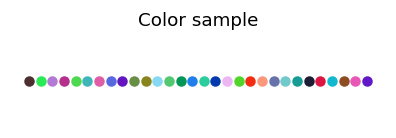

In [12]:
ns=30  # run also for 3, 4, 5, 30, 500
# random sample of ns colors

samp=[[np.random.random(),np.random.random(),np.random.random()] for _ in range(ns)]

#samp=[[np.random.random(),0,0] for _ in range(ns)] # one color

# RGB
# samp=[[1,0,0],[0,1,0],[0,0,1]]

pls=plt.figure(figsize=(4,1),dpi=120)
plt.title("Color sample",fontsize=11) 

plt.axis('off')

for i in range(ns):
    plt.scatter(i/ns,0,color=samp[i], s=25000/ns**2); 

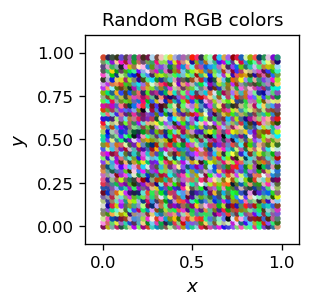

In [13]:
size=40  # neuron array of size x size (40 x 40)

tab=np.zeros((size,size,3)) 

for i in range(size):      
    for j in range(size):  
        for k in range(3): # 3 RGB components
#        for k in range(1): # color intensity
            tab[i][j][k]=np.random.random() # random initialization

plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Random RGB colors",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for i in range(size):
    for j in range(size):
        plt.scatter(i/size,j/size,color=tab[i][j], s=8) 
plt.xlabel('$x$',fontsize=11)
plt.ylabel('$y$',fontsize=11);

In [14]:
eps=.5   
de = 7  # (25 for small samples, 1 for bigger)
rep= 1   # repeats without changing eps and de (4,1)

Do step by step

In [15]:
for _ in range(100):  # rounds
    eps=eps*.99      
    de=de*.96        
    for _ in range(rep):    
        for s in range(ns): # loop over the data sample       
#            p=[np.random.random(),np.random.random(),np.random.random()] # random RGB
            p=samp[s] # poin of the sample
            dist=[[dist3(p,tab[i][j]) for j in range(size)] for i in range(size)] 
                # distance in color to all neurons
            ind_min = np.argmin(dist) # winner index
            ind_x=ind_min//size       # a trick to get a 2-dim index
            ind_y=ind_min%size
#            print(dist)
#            print(ind_x, ind_y, dist[ind_x][ind_y], tab[ind_x][ind_y])

            for j in range(size): 
                for i in range(size):
                    tab[i][j]+=eps*phi2(ind_x,ind_y,i,j,de)*(p-tab[i][j]) 
                      # update
         

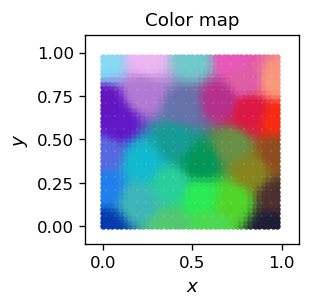

In [16]:
fig0=plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Color map",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for i in range(size):
    for j in range(size):
        plt.scatter(i/size,j/size,color=tab[i][j], s=8)

plt.xlabel('$x$',fontsize=11)
plt.ylabel('$y$',fontsize=11);

# print(eps,de) 

### Comments

- The algorithm divides the data into clusters in the sense that close data points are mapped to nearby neurons.

- The final result is not unequivocal, i.e. running the algorithm with a different initialization of the weights gives a different division, equally "good".

- The areas for the individual colors of the sample have a comparable area. Generally, the area is proportional to the sample size.

- To get sharper boundaries between regions, de has to shrink faster than eps. Then, in the final stage of learning, the neural adaptation process takes place for small neighborhood distances.

- It makes no sense to consider the case when the dimension of the neural network is greater than the dimension of the data.


First show the U matrix below. Then go back and run for different de values and for different sample sizes, and also for an infinite sample and for a single color.

## Unified distance matrix

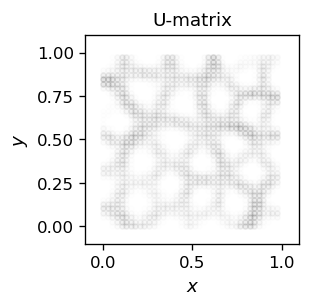

In [17]:
siz=size-1 

ta=np.zeros((siz,siz))

sc=0.25

for i in range(siz):
    for j in range(siz):
        ta[i][j]=sc*np.sqrt(dist3(tab[i][j],tab[i][j+1])+
                            dist3(tab[i][j+1],tab[i+1][j+1])+
                            dist3(tab[i+1][j+1],tab[i+1][j])+
                            dist3(tab[i+1][j],tab[i][j]))
        # sum of squares of distances around the plaquette
        
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("U-matrix",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for i in range(siz):
    for j in range(siz):
        plt.scatter(i/siz,j/siz,color=[0,0,0,ta[i][j]], s=10) 

plt.xlabel('$x$',fontsize=11)
plt.ylabel('$y$',fontsize=11);

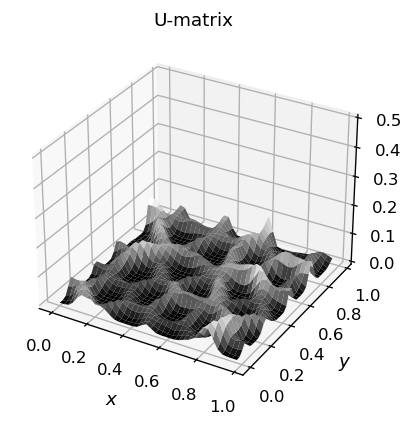

In [18]:
fig = plt.figure(figsize=(4,4),dpi=120)
axes1 = fig.add_subplot(111, projection="3d")
ax = fig.gca(projection='3d')

xx_1 = np.arange(0, 1, 1./siz)
xx_2 = np.arange(0, 1, 1./siz)

x_1, x_2 = np.meshgrid(xx_1, xx_2)

Z=np.array([[ta[i][j] for i in range(siz)] for j in range(siz)])

ax.set_zlim(0,.5)

ax.plot_surface(x_1,x_2, Z, cmap=cm.gray)

# plt.axis('off')
plt.xlabel('$x$',fontsize=11)
plt.ylabel('$y$',fontsize=11);

plt.title("U-matrix",fontsize=11);


Distance map for a given (new) data point (i.e. using a classifier)

In [19]:
nd=[np.random.random(),np.random.random(),np.random.random()]

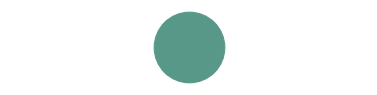

In [20]:
plt.figure(figsize=(6.5,1.5))

plt.axis('off')
plt.scatter(0,0,color=nd, s=5000); 

Classification of the point according to the previously obtained map

In [21]:
tad=np.zeros((size,size))

for i in range(size):
    for j in range(size):
        tad[i][j]=dist3(nd,tab[i][j])
        

ind_m = np.argmin(tad) # winner
in_x=ind_m//size      
in_y=ind_m%size 

da=np.sqrt(tad[in_x][in_y])

print("Closest neuron coordinates: (",in_x/size,in_y/size,")")
print("Distance: ",np.round(da,3))

Closest neuron coordinates: ( 0.575 0.55 )
Distance:  0.118


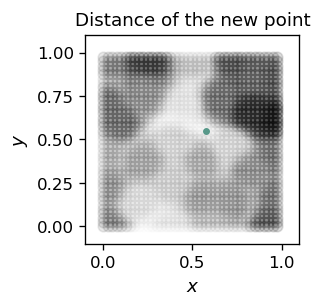

In [22]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Distance of the new point",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for i in range(size):
    for j in range(size):
        plt.scatter(i/size,j/size,color=[0,0,0,tad[i][j]/3], s=40) 
        
plt.scatter(in_x/size,in_y/size,color=nd, s=10) 

plt.xlabel('$x$',fontsize=11)
plt.ylabel('$y$',fontsize=11);

Comment

We have a classifier that assigns a position in a space with a reduced number of dimensions.

## Mapping colors on a line

Reduction of three dimensions into one

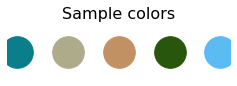

In [23]:
ns=5  # do for 3, 4, 5
# random sample
samp=[[np.random.random(),np.random.random(),np.random.random()] for _ in range(ns)]

# RGB
# samp=[[1,0,0],[0,1,0],[0,0,1]]

fig1=plt.figure(figsize=(4,1))
plt.title("Sample colors",fontsize=16) 

plt.axis('off')

for i in range(ns):
    plt.scatter(i/ns,0,color=samp[i], s=25000/ns**2);

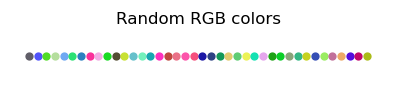

In [24]:
si=40  # 1D array of si neurons

tab2=np.zeros((si,3))

for i in range(size):      
    for k in range(3): # 3 RGB components
        tab2[i][k]=np.random.random() # random initialization

plt.figure(figsize=(4,0.5),dpi=120)
plt.title("Random RGB colors",fontsize=10) 
plt.axis('off')

for i in range(si):
    plt.scatter(i/si,0,color=tab2[i], s=25000/si**2); 

In [25]:
eps=.5    
de = 20   
rep= 1    

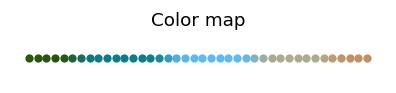

In [26]:
for _ in range(100): 
    eps=eps*.99      
    de=de*.96        
    for _ in range(rep):    
        for s in range(ns):       
#            p=[np.random.random(),np.random.random(),np.random.random()] # random RGB
            p=samp[s] # punkt próbki
            dist=[dist3(p,tab2[i]) for i in range(si)] 
            ind_min = np.argmin(dist) 
         
            for i in range(si):
                tab2[i]+=eps*phi(ind_min,i,de)*(p-tab2[i]) 

fig2=plt.figure(figsize=(4,.5),dpi=120)
plt.title("Color map",fontsize=11) 
plt.axis('off')

for i in range(si):
    plt.scatter(i/si,0,color=tab2[i], s=25000/si**2); 

Smooth transition between colors.

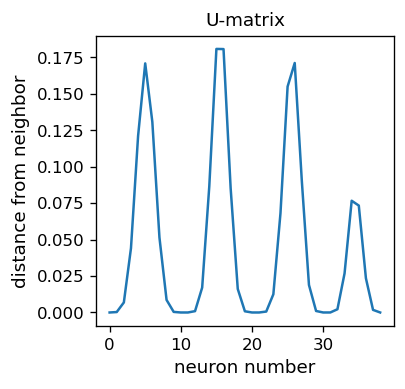

In [27]:
si2=si-1

xr=np.array([i for i in range(si2)])

ta2=np.zeros(si2)

for i in range(si2):
    ta2[i]=np.sqrt(dist3(tab2[i],tab2[i+1]))
        
plt.figure(figsize=(3.2,3.2),dpi=120)
plt.title("U-matrix",fontsize=11) 

plt.plot(xr,ta2) 

plt.xlabel('neuron number',fontsize=11)
plt.ylabel('distance from neighbor',fontsize=11);

The minima correspond to the individual colors of the sample. The height of the separating peaks shows how much the colors differ.

The most similar colors are not necessarily adjacent. The behavior depends on the value of the de parameter.

## Mapping two-dimensional data into a two-dimensional network

In [28]:
def point():
    x=np.random.random()
    y=np.random.random()
    return np.array([x,y])

In [29]:
n=10
sam=np.array([func.point() for _ in range(n*n)])

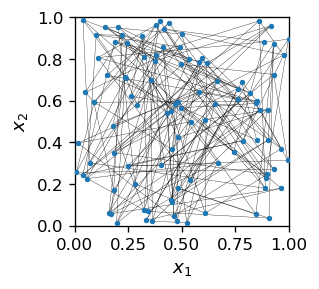

In [30]:
plt.figure(figsize=(2.3,2.3),dpi=120)

plt.xlim(0,1)
plt.ylim(0,1)
 
plt.scatter(sam[:,0],sam[:,1],s=5,zorder=3)

for j in range(n):       # rows
    for i in range(n-1): # columns
        plt.plot([sam[i+n*j,0],sam[i+1+n*j,0]],[sam[i+n*j,1],sam[i+1+n*j,1]],
                 linewidth=.2,c='black')

for j in range(n-1):       # rows
    for i in range(n): # columns
        plt.plot([sam[i+n*j,0],sam[i+n*(j+1),0]],[sam[i+n*j,1],sam[i+n*(j+1),1]],
                 linewidth=.2,c='black')
        
        
plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11);    

In [31]:
eps=.5   # początkowa szybkość uczenia (0.5)
de = 3   # początkowy promień sąsiedztwa 
nr=400
rep= 300 # powtórzenia po próbce bez zmiany eps i de

In [32]:
for _ in range(nr):  # rundy z uaktualnieniem eps i de (100)
    eps=eps*.97      # uczenie słabnie z każdą rundą
    de=de*.98        # promień sąsiedztwa też maleje 
    for _ in range(rep):    # powtórz bez uaktualniania eps i de
        p=point() # punkt próbki
#        print(p)
        dist=[func.eucl(p,sam[l]) for l in range(n*n)] 
          # tablica kwadratów euklidesowych odległości od p dla wsyzstkich neuronów
        ind_min = np.argmin(dist) # wskaźnik zwycięzcy
        ind_i=ind_min%n
        ind_j=ind_min//n       # tak trzeba wyłowić wskaźnik dwuwymiarowy (!)
#        print(dist)
#        print(ind_x, ind_y, dist[ind_x+n*ind_y], sam[ind_x+n*ind_y])

        for j in range(n): 
            for i in range(n):
                sam[i+n*j]+=eps*phi2(ind_i,ind_j,i,j,de)*(p-sam[i+n*j]) 
                      # aktualizacja wg strategii "zwycięzca bierze wiekszość"
   

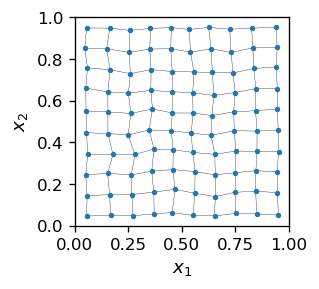

In [33]:
plt.figure(figsize=(2.3,2.3),dpi=120)

plt.xlim(0,1)
plt.ylim(0,1)
 
plt.scatter(sam[:,0],sam[:,1],s=5,zorder=3)

for j in range(n):       # rows
    for i in range(n-1): # columns
        plt.plot([sam[i+n*j,0],sam[i+1+n*j,0]],[sam[i+n*j,1],sam[i+1+n*j,1]],
                 linewidth=.2,c='black')

for j in range(n-1):       # rows
    for i in range(n): # columns
        plt.plot([sam[i+n*j,0],sam[i+n*(j+1),0]],[sam[i+n*j,1],sam[i+n*(j+1),1]],
                 linewidth=.2,c='black')
        
        
plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11);    

The $ f $ mapping
has the following **topological** property: if two neurons $ n_1 $ and $ n_2 $ are close to each other, then also $ d_1 = f (n_1) $ and $ d_2 = f (n_2) $ are close. As we will see, this allows for "transferring" of structures from the $ D $ data space to the $ N $ neuron space.

Such a mechanism takes place, for example, in the visual system ...

Topology of the vision

In this case, preserving the topology means that, for example, a retinal circle is mapped into a loop in the cerebral cortex. 

Mapping the retina into the visual area of the cerebral cortex

### Wikipedia articles' similarity

Reduction from very many parameters into 2. U-matrix.

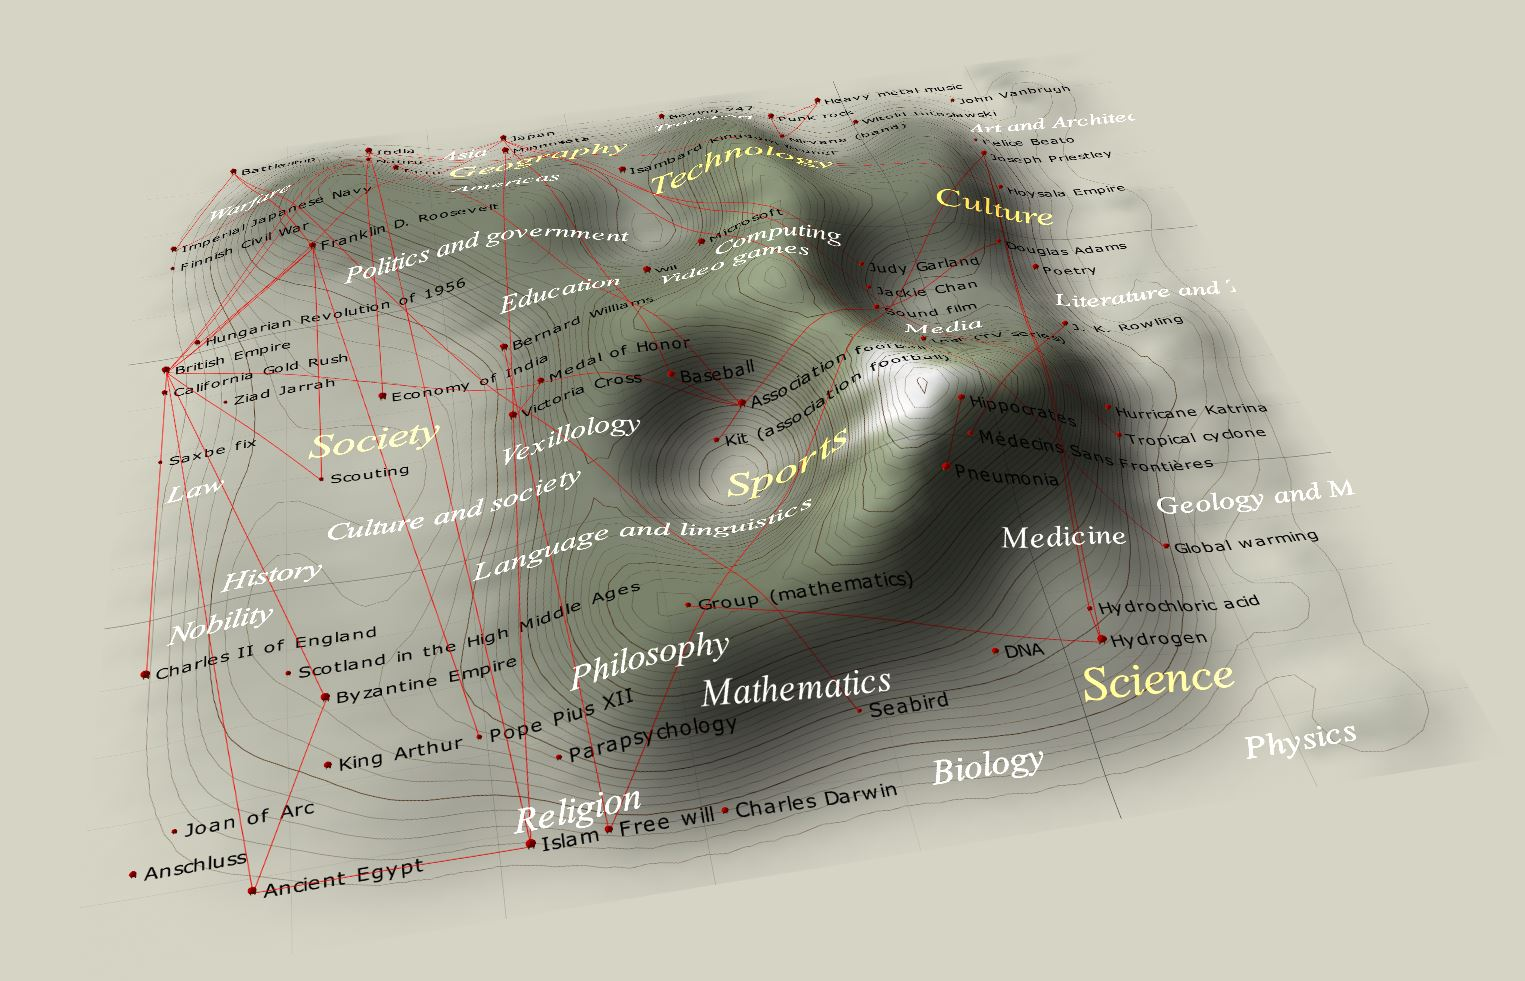

In [34]:
Image(filename="images/Self_oraganizing_map_cartography.jpg",width=620)

[Wikipedia] Cartographical representation of a self-organizing map (U-Matrix) based on Wikipedia featured article data (word frequency). Distance is inversely proportional to similarity. The "mountains" are edges between clusters. The red lines are links between articles.

## Lateral inhibition

Final missing link: how to make the winner-take-all/most

:::{figure-md} lat-fig

<img src="images/lat2.png" width="170px">

Network with inter-neuron coupling used for modeling lateral inhibition.
:::

$$ 
y_i = s_i + \sum_{j\neq i} F_{ij} y_j.
$$

$$
\sum_j (\delta_{ij}-F_{ij}) y_j = s_i , ~~~s_i = x w_i, ~~~ F_{ii}=0.
$$

$$ (I-F) y = s $$

$$ y= (I-F)^{-1} s $$


Coupling (damping) matrix:

We will take, for example

$ F_ {ii} = $ 0,

$ F_ {ij} = - a \exp (- | i-j | / b) ~~ $ for $ i \neq j $, $ ~~ a, b> 0 $,

i.e. attenuation is strongest for close neighbors and it decreases with distance with a characteristic scale $b$.

In [35]:
ns = 30;       # number of neurons
b = 4;         # parameter controling the decrease of damping with distance
a = 1;         # magnitude of damping
eps = .1;      # coupling parameter

F=np.array([[-a*np.exp(-np.abs(i-j)/b) for i in range(ns)] for j in range(ns)]) 
                    # exponential fall-off
    
for i in range(ns):
    F[i][i]=0       # no self-damping
    

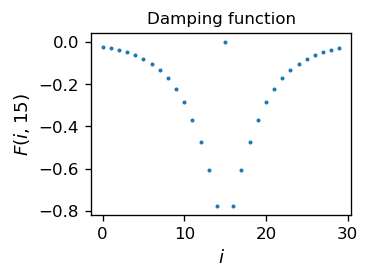

In [36]:
plt.figure(figsize=(2.8,2),dpi=120)
plt.title("Damping function",fontsize=10) 

ii=[i for i in range(ns)]
ff= [F[i][15] for i in range(ns)]

plt.scatter(ii,ff,s=2)

plt.xlabel('$i$',fontsize=11)
plt.ylabel('$F(i,15)$',fontsize=11);    

In [37]:
s = np.array([2**2/((i - ns/2)**2 + 2**2) for i in range(ns)]) # Lorentzian function

invF=np.linalg.inv(np.identity(ns)-F) # matrix inversion
y=np.dot(invF,s)                      # multiplication
y=y/y[15]                             # normalization 

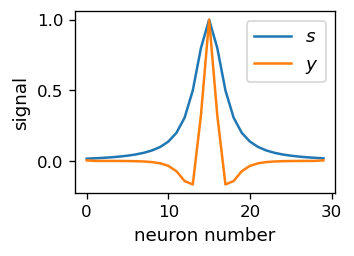

In [38]:
plt.figure(figsize=(2.8,2),dpi=120)

plt.plot(s)
plt.plot(y)
plt.legend(('$s$','$y$'),fontsize=11)
plt.xlabel('neuron number',fontsize=11)
plt.ylabel('signal',fontsize=11);    

Pyramidal neurons


```{admonition} Exercises
:class: warning

Construct a Kohonen mapping form a 2D shape (square, cicle, 2 disjoint squares) on a 2D grid of neurons.
```